# Prototipo de MoDem especializado en la técnica LoRa para la transmisión y recepción en SDRs (V 0.2.0)



## Implementación del MoDem LoRa


La modulación LoRa se podría catalogar como una **manera sistemática de encapsular símbolos** a través de distintas configuraciones en la evolución lineal de la frecuencia para una señal chirp, actuante de portadora.



### Definición y parámetros

Para poder llevar a cabo la implementación del MoDem, es necesario tener en cuenta aquellos parámetros del sistema de comunicación que se deban mantener a lo largo de cada transmisión. Así como en AM uno sintoniza a una frecuencia específica para estar en sintonía el transmisor con el receptor, en LoRa deberemos manifestar estos parámetros *externos*:

- Bandwidth (Ancho de Banda): El ancho de banda especificado para una transimisión LoRa deberá ser especificado ya que definirá los límites inferiores y superiores en los que la frecuencia presentará esta variación. Es decir, si establecemos un ancho de banda de por ejemplo $Bw = 125$ kHz, se tendrá entonces una evolución de la frecuencia siempre entre esos valores. 
  
- Spreading Factor (Factor de expansión): Este parámetro engloba dos responsabilidades: Representar la cantidad de bits que se podrán transmitir en un símbolo y que tanto se esparcirá en el tiempo (es decir, su duración) la transmisión del símbolo.

- WIP: Ver si se puede además pedir un factor (ya sea booleano o entero) de oversampling para amplificar la cantidad de muestras, con el objetivo de mejorar la apreciación gráfica de lo transmitido.
  
Además, podemos catalogar a los parámetros *internos* como aquellos que se deducen directamente a partir de los parámetros internos antes mencionados, así poder reutilizarlos como variables una vez se realice el código:

- Chips y Número de Chips: El chip representa la unidad fundamental de información, resultante de la expansión realizada por el $SF$. Es equivalente (aunque no son sinónimos) con la cantidad de combinaciones posibles para transmitir un símbolo, a saber: $N_{C}= 2^{SF}$. Es decir, que el chip es el item de menor expresión en la secuencia de evolución de frecuencia a lo largo del tiempo. (Es decir, la mínima cantidad de muestras que mantiene el concepto de la técnica LoRa)

- Samples Per Symbol (Muestras por símbolo): Representa cuantos puntos se renderizarán en la función discreta. Para ello, podremos calcularla como: $SPS = N_{C}$. Con que las muestras por símbolo equivalgan al número de chips, ya se tiene una representación suficiente, debido al teorema de Nyquist aplicado para señales I/Q analíticas en el plano complejo.

- Symbol Duration (duración por símbolo): Representa cuanto tiempo le tomará a nuestro chirp barrer todo el ancho de banda. Este se calcula como: $T_S= \frac{N_{C} - 1}{Bw}$. Debido a la discretización de las muestras, se le resta uno a la cantidad de chips para no excederse. Esta es la diferencia implementada por nosotros en contraposición al artículo de Lorenzo Evangelista.

- Frequency Slope (pendiente de frecuencia): Representa la tasa de cambio de la evolución lineal de nuestra frecuencia. Se calcula como cualquier otra pendiente. Sabemos que sí o sí se recorrerá una distancia en $\Delta Y$ equivalente al ancho de banda y sabemos la duración del símbolo $\Delta t$ ya que se mencionó anteriormente.

    $m_f = \frac{\Delta Y}{\Delta t} =  \frac{(Bw - 0)}{\frac{N_{C}-1}{Bw}-0} = \frac{Bw^2}{N_c - 1}$



### Matemática del código: Transmitiendo y modulando símbolos



Para transmitir un símbolo $c_i$, se empieza por la determinación evolutiva de la frecuencia a través del tiempo.
Como se dijo anteriormente, esta será de naturaleza lineal, con la ecuación:

$f(c,t) = b(c) + m \cdot t$

Donde la pendiente $m$ es la pendiente establecida con anterioridad: $m = \frac{Bw^2}{N_c - 1}$ y la ordenada al origen se define como la ponderación del símbolo en el espectro de frecuencia:

$b(c)= c\cdot\frac{Bw}{2^{SF}}$

De esta forma, se puede catalogar a la función "evolución de frecuencia a lo largo del tiempo para un símbolo transmitido $c_i$", cómo:

$f_i(t)=c_i\cdot\frac{Bw}{2^{SF}} + \frac{Bw^2}{N_c - 1} \cdot t$

Sin embargo, el lector rápidamente podrá observar que no se está teniendo en cuenta la discontinuidad del ancho de banda en la ecuación. Para ello, se empleará también la nomenclatura vista en el libro de *Bixio Grimoldi*, en relación a la función especial indicadora, que toma el valor de $1$ sí y solo sí se cumple una asignación lógica asociada. Para mejorar la lectura, se definirán dos funciones: $f'_i$, la cual no tiene discontinuidades, y $f_i$, que reemplazará a la anterior versión para tener en cuenta los límites del ancho de banda. A saber:


$f'_i(t)=c_i\cdot\frac{Bw}{2^{SF}} + \frac{Bw^2}{N_c - 1} \cdot t $

$f_i(t)= f'_i(t) - Bw\cdot \Chi _{ \{  f'_i(t) > Bw \} }$

Una vez conseguida la evolución de frecuencia a lo largo del tiempo, se puede determinar la señal final a transmitir:

$s_i(t) = \frac{1}{\sqrt{2^{SF}}}\cdot e^{j 2\pi f_i(t) t}$



## Modulador LoRa

In [60]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt

class LoraReservedArtifacts(Enum):
    FULL_UPCHIRP = 0
    FULL_DOWNCHIRP = 1
    QUARTER_DOWNCHIRP = 2
    
class LoraModulator():
    def __init__(self, spreading_factor, bandwidth, samples_per_chirp = 1):
        # LoRa technique external parameters
        self.__spreading_factor = spreading_factor
        self.__bandwidth = bandwidth
        self.__samples_per_chirp = samples_per_chirp
        # Lora technique internal parameters
        self.__chips_number = 2 ** spreading_factor
        self.__symbol_duration = ( self.__chips_number - 1 ) / bandwidth
        self.__samples_per_symbol = int((self.__chips_number - 1) * samples_per_chirp + 1)
        self.__frequency_slope = (bandwidth ** 2) / (self.__chips_number - 1)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol
    
    def generate_frequency_evolution_across_time(self, symbols, return_only_offset_time_axis = True):

        frequency_evolution = []
        time_axis = []
        time_axis_without_offset = []
        current_offset = 0
        
        for symbol in symbols:

            current_slope = self.__frequency_slope
            symbol_time_axis = np.linspace(current_offset, current_offset + self.__symbol_duration, self.__samples_per_symbol)

            if symbol == LoraReservedArtifacts.FULL_UPCHIRP:
                symbol = 0

            elif symbol == LoraReservedArtifacts.FULL_DOWNCHIRP:
                symbol = 2**self.__spreading_factor
                current_slope = - current_slope
            
            elif symbol == LoraReservedArtifacts.QUARTER_DOWNCHIRP:
                symbol = 2**self.__spreading_factor
                current_slope = - current_slope
                quarter_cycle_max_index = int(len(symbol_time_axis) // 4 + 1)
                symbol_time_axis = symbol_time_axis[:quarter_cycle_max_index]

            y_intercept = symbol * ( self.__bandwidth / (2**self.__spreading_factor) )
            
            for i in range(len(symbol_time_axis)):
                instantaneous_frequency = y_intercept + current_slope * (symbol_time_axis[i] - current_offset)

                if instantaneous_frequency >= self.__bandwidth:
                    # Not necesarry to take into account multiples of bandwidth, as the duration of the chirp is limited 
                    instantaneous_frequency -= self.__bandwidth


                frequency_evolution.append(instantaneous_frequency)

            time_axis.extend(symbol_time_axis)
            symbol_time_axis_without_offset = symbol_time_axis - current_offset
            time_axis_without_offset.extend(symbol_time_axis_without_offset)
            
            time_stop = symbol_time_axis[-1] + self.__sampling_period
            current_offset = time_stop
            
            if return_only_offset_time_axis:
                return time_axis, frequency_evolution
            if not return_only_offset_time_axis:
                return time_axis, time_axis_without_offset,frequency_evolution
            return time_axis, frequency_evolution
    
    def generate_chirp_from_frequency_evolution(self, time_axis, frequency_evolution):
        coefficient = 1/np.sqrt(2**self.__spreading_factor)
        signal = []
        for i in range(len(time_axis)):
            instantaneous_phase = 1j * 2 * np.pi * frequency_evolution[i] * time_axis[i]
            signal_sample = coefficient * np.exp(instantaneous_phase)
            signal.append(signal_sample)
        return signal

    def modulate_symbols(self, symbols, also_return_frequency_evolution = False):
        for symbol in symbols:
            if symbol not in range(self.__chips_number) and not isinstance(symbol, LoraReservedArtifacts):
                raise ValueError(f"Symbols have to be of type LoraReservedArtifacts or integers between 0 and {self.__chips_number - 1} for the given spreading factor")
        time_axis, no_offset_time_axis, frequency_evolution = self.generate_frequency_evolution_across_time(symbols, False)
        signal = self.generate_chirp_from_frequency_evolution(no_offset_time_axis, frequency_evolution)
        if not also_return_frequency_evolution:
            return time_axis, signal
        return time_axis, signal, frequency_evolution

    
    def modulate_implicit_package(self,preamble_number, payload, also_return_frequency_evolution = False):
        package = []
        for i in range(preamble_number):
            package.append(LoraReservedArtifacts.FULL_UPCHIRP)
        for i in range(2):
            package.append(LoraReservedArtifacts.FULL_UPCHIRP)
        for i in range(2):
            package.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
        package.append(LoraReservedArtifacts.QUARTER_DOWNCHIRP)

        package.extend(payload)
        time_axis, signal, frequency_evolution = self.modulate_symbols(package, True)
        if not also_return_frequency_evolution:
            return time_axis, signal
        return time_axis, signal, frequency_evolution
    
    @property
    def spreading_factor(self):
        return self.__spreading_factor
    @spreading_factor.setter
    def spreading_factor(self, value):
        if value not in [7, 8, 9, 10, 11, 12]:
            raise ValueError("Spreading factor has to be one of the integers: 7, 8, 9, 10, 11 or 12")
        self.__spreading_factor = value
        self.__chips_number = 2 ** value
        self.__symbol_duration = self.__chips_number / self.__bandwidth
        self.__samples_per_symbol = int(self.__chips_number * self.resolution_between_chips)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol
        self.__frequency_slope = (self.__bandwidth ** 2) / self.__chips_number

    @property
    def bandwidth(self):
        return self.__bandwidth
    @bandwidth.setter
    def bandwidth(self, value):
        if value not in [125, 250, 500]:
            raise ValueError("Bandwidth has to be one of the integers: 125, 250 or 500. Remember that it is in kHz.")
        self.__bandwidth = value
        self.__symbol_duration = self.__chips_number / value
        self.__samples_per_symbol = int(self.__chips_number * self.resolution_between_chips)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol
        self.__frequency_slope = (value ** 2) / self.__chips_number

    @property
    def resolution_between_chips(self):
        return self.__resolution_between_chips
    @resolution_between_chips.setter
    def resolution_between_chips(self, value):
        if value < 1:
            raise ValueError("Resolution between chips has to be greater than 0")
        if value % 2 != 0:
            print("Be careful, the resolution between chips is not a multiple of 2. This may lead to errors.")
        self.__resolution_between_chips = value
        self.__samples_per_symbol = int(self.__chips_number * value)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol




## Demodulador Lora


In [52]:
class LoraDemodulator:
    def __init__(self, spreading_factor, bandwidth,oversampling_factor = 1):
        # The spreading factor of the LoRa modulation
        self.spreading_factor = spreading_factor
        
        # The bandwidth of the LoRa modulation in KiloHertz
        self.bandwidth = bandwidth

        self.__oversampling_factor = oversampling_factor
    
    def generate_full_downchirp(self):
        # Number of discrete levels in the transmitted symbol that eventually will be mapped to a frequency
        chips_number = 2**self.spreading_factor

        # Number of samples per symbol
        samples_per_symbol = int(chips_number)

        # Time duration of each symbol
        symbol_duration = (chips_number - 1)/np.abs(self.bandwidth)

        sampling_period = symbol_duration/samples_per_symbol

        # Slope of the downchirp, defined by the bandwidth and the time duration of each symbol
        slope = - (self.bandwidth**2) /(chips_number - 1)

        y_intercept = self.bandwidth

        # Frequency evolution of the chirp signal
        symbol_frequency_evolution = []

        symbol_time_axis = np.linspace(0, symbol_duration, (samples_per_symbol-1) * self.__oversampling_factor +1)
        # Signal
        signal = []

        for i in range(len(symbol_time_axis)):
                
            # Instantaneous frequency of the chirp signal
            instantaneous_frequency = ( y_intercept + slope * symbol_time_axis[i] )

            symbol_frequency_evolution.append(instantaneous_frequency) 

            instantaneous_phase = 1j * 2 * np.pi * instantaneous_frequency * symbol_time_axis[i] 
            coefficient = 1 / (np.sqrt(2**self.spreading_factor))
            signal.append(coefficient * np.exp(instantaneous_phase))

        return symbol_time_axis, symbol_frequency_evolution, signal
        
    def dechirp_symbol(self, signal):
        downchirp_signal = self.generate_full_downchirp()[2]
        dechirped_signal = [signal[i] * downchirp_signal[i] for i in range(len(signal))]
        return dechirped_signal
    
    def demodulate_symbol(self, signal, return_only_symbol = True):
        dechirped_signal = self.dechirp_symbol(signal)
        correlation = np.fft.fft(dechirped_signal)
        observed_symbol = np.argmax( np.abs(correlation[:2**self.spreading_factor]))
        if return_only_symbol:
            return observed_symbol
        return observed_symbol, correlation

In [10]:
def signal_power(signal):
    # Calculate the signal power
    P = np.mean(np.abs(signal)**2)
    return P


def noise_generator(SNR, w):
    # Check if SNR is given in dB, DB, or db and convert if necessary
    if isinstance(SNR, str) and SNR.lower().endswith('db'):
        # Extract the numeric part and convert from dB to linear scale
        SNR_value = float(SNR[:-2])  # Remove the last two characters and convert to float
        SNR_linear = 10 ** (SNR_value / 10)
    else:
        # Assume SNR is already in linear scale
        SNR_linear = SNR
    
    # Determine the noise power (variance)
    variance = signal_power(w) / SNR_linear
    std_dev = variance ** 0.5
    # Generate noise
    N = [np.random.normal(0, std_dev) for _ in w]
    noisy_signal = [w[i] + N[i] for i in range(len(w))]
    return noisy_signal, N, variance

In [11]:
def ber_vs_snr(sf, bw, sims):
    modulator = LoraModulator(sf, bw)
    demodulator = LoraDemodulator(sf, bw)
    snr_range = np.linspace(-25, 0, 26)
    ber = []
    for snr in snr_range:
        errors = 0
        for _ in range(sims):
            symbol = [np.random.randint(0, 2**sf)]
            time_axis, signal = modulator.modulate_symbols(symbol)
            db_snr = f"{snr}dB"
            noisy_signal, _, _ = noise_generator(db_snr, signal)
            observed_symbol = demodulator.demodulate_symbol(noisy_signal)
            if observed_symbol != symbol[0]:
                errors += 1
        ber.append(errors / sims)
   
    plt.plot(snr_range, ber)

In [63]:
def test_all():
    for sf in [7,8,9,10,11,12]:
        lm = LoraModulator(sf, 125, 1)
        ld = LoraDemodulator(sf, 125, 1)
        errors = 0
        for i in range(2**sf):
            time_axis, signal = lm.modulate_symbols([i])
            observed_symbol = ld.demodulate_symbol(signal)
            if i != observed_symbol:
                errors += 1
                print(f"Error in spreading factor {sf}, symbol {i}")
                assert False
            


test_all()

KeyboardInterrupt: 

Observed symbol: 127


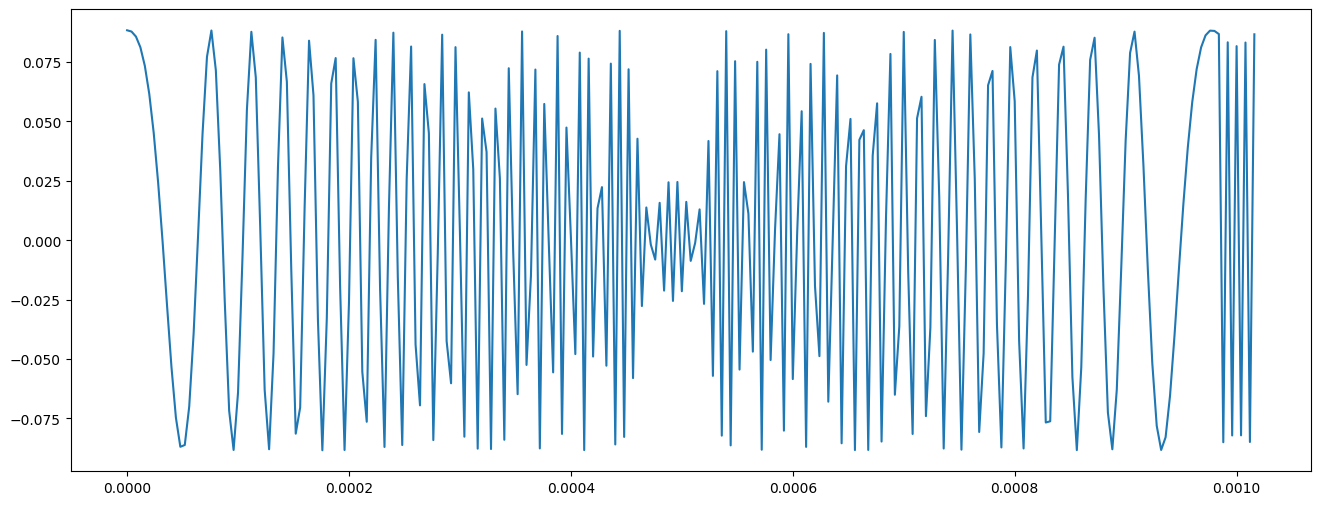

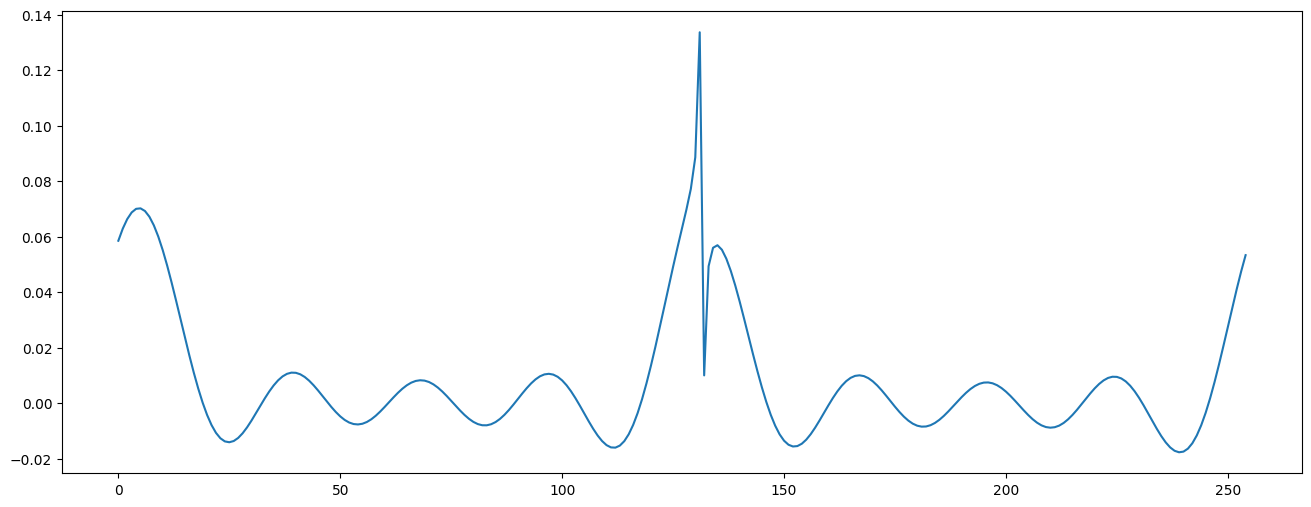

In [66]:
lora_md = LoraModulator(7, 125000, 2)
lora_dm = LoraDemodulator(7, 125000, 2)

symbols = [4]
# Errors start to appear at a 0.003 SNR 
time_axis, signal = lora_md.modulate_symbols(symbols)

plt.figure(figsize=(16, 6))
plt.plot(time_axis, np.real(signal))

observed_symbol, correlation = lora_dm.demodulate_symbol(signal, False)

plt.figure(figsize=(16, 6))
plt.plot(correlation)

print(f"Observed symbol: {observed_symbol}")

# plt.figure(figsize=(12, 6))
# for sf in [7, 8, 9, 10, 11, 12]:
#     ber_vs_snr(sf, 125000, 1000)

